# Water supply in Spain

## Project Idea: 
Compare different datasets regarding water availibility to answer for example the following questions:
 *   How does weather influence water reserve amounts?
 *   How does weather influence the amount of water flowing in rivers?
 *   How does weather influence water quality?
 * Is there a regional difference within spain ? (If data is given)


 ## Data sets:
 
 1. Weather data:
    *  Meteostat: https://github.com/meteostat/meteostat-python
    * The Meteostat Python library provides a simple API for accessing open weather and climate data. The historical observations and statistics are collected by Meteostat from different public interfaces, most of which are governmental.
 2. river_water_spain
    * River levels history data set
    * Obtained from: https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#dataDownload/Stations
    * Created account , requested access, filtered by spain, downloaded
 3. water_availability_spain.xlsx
    * Water supply data from INE Spain:https://www.ine.es/buscar/searchResults.do?searchString=Spain+Public+Water+Supply&Menu_botonBuscador=&searchType=DEF_SEARCH&startat=0&L=1
    * Data chosen for year and region of spain
4. Waterbase_v2021_1_WISE2_csv
    * Water Quality EU wide for with year and spatial information
    * Obtained from: https://www.eea.europa.eu/data-and-maps/data/waterbase-biology-1

## Overview-Diagram:






![Diagram](Diagram.drawio.png)


## 1 Weather Data
First let's get the weather data for spain from 2000 until now. Especially we are interested in rain amount, temperature and sun hours per region. 

In [15]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Stations
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pyodbc
from getpass import getpass
import json
from pathlib import Path

In [3]:
# Set time period from 2000 to now
start_date = datetime(2000, 1, 1)
end_date = datetime(2020, 12, 31)

In [4]:
#get all weather stations in spain
stations_es = Stations().region("ES").fetch()
#keep only the ones which have daily weather data from 2000 until 2020
stations_es = stations_es[
        (stations_es["daily_start"] <= start_date)
        & (stations_es["daily_end"] >= end_date)
    ]

print(stations_es.shape)
stations_es.head()

(83, 15)


name country region    wmo  icao  latitude  longitude  \
id                                                                            
08001            La Coruna      ES     GA  08001  <NA>   43.3667    -8.4167   
08002  La Coruna / Alvedro      ES     GA  08002  LECO   43.3000    -8.3833   
08008         Lugo / Rozas      ES     GA  08008  <NA>   43.1167    -7.4500   
08011    Asturias / Aviles      ES      O  08011  LEAS   43.5500    -6.0333   
08014                Gijon      ES      O  08014  <NA>   43.5333    -5.6333   

       elevation       timezone hourly_start hourly_end daily_start  \
id                                                                    
08001       58.0  Europe/Madrid   2018-01-27 2023-03-26  1930-10-01   
08002       97.0  Europe/Madrid   1974-10-01 2023-03-26  1971-12-01   
08008      445.0  Europe/Madrid          NaT        NaT  1951-01-01   
08011      127.0  Europe/Madrid   1973-01-01 2023-03-26  1968-08-01   
08014        3.0  Europe/Madrid          NaT        NaT  1973-01-01   

       daily_end monthly_start monthly_end  
id                                          
08001 2023-03-20    1930-01-01  2022-01-01  
08002 2023-03-20    1971-01-01  2022-01-01  
08008 2023-03-21    1951-01-01  2022-01-01  
08011 2023-03-17    1968-01-01  2022-01-01  
08014 2022-12-31    1982-01-01  2022-01-01

In [5]:
#get all regions vailable in spain
print(stations_es.region.unique())

<StringArray>
['GA',  'O',  'S', 'PV', 'CL', 'LO', <NA>, 'AR', 'CT',  'M', 'CM', 'EX', 'VC',
 'IB', 'AN', 'MU', 'CN', 'CE', 'ML']
Length: 19, dtype: string


In [6]:
#filter NA value
regions = stations_es.region.unique()
valid_regions = [region for region in regions if pd.pandas.notna(region)]
stations_es = stations_es[stations_es.region.isin(valid_regions)]
print(valid_regions)
print(len(valid_regions))

['GA', 'O', 'S', 'PV', 'CL', 'LO', 'AR', 'CT', 'M', 'CM', 'EX', 'VC', 'IB', 'AN', 'MU', 'CN', 'CE', 'ML']
18


In [7]:
stations_es.shape

(81, 15)

In [10]:
regional_dfs= {}
# loading the df from the API takes quite a while. We save it instead in Azure BLOB storage and load it from there
#for region in valid_regions:
#    regional_dfs[region] = Daily(stations_es[stations_es.region==region], start_date, end_date).aggregate(spatial=True).fetch()
#    regional_dfs[region]["region"] = region

In [24]:
from azure.storage.blob import BlobServiceClient,BlobClient
connection_string="DefaultEndpointsProtocol=https;AccountName=jhornteststorage;AccountKey=oXFFpr2+QKYu6AzzCEb4BI5dgytxywKwDZrasv8f0ixODRwqWVOeUuGWLtU8MGBe4ATxPMGuT/h4+AStK9enGQ==;EndpointSuffix=core.windows.net"
container_name="mycontainer"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

#DATA IS ALREADY UPLOADED
#Path("./pickled_weather_dfs").mkdir(parents=True, exist_ok=True)
#for region in valid_regions:
#    file_name = "./pickled_weather_dfs/"+str(region)+".pkl"
#    regional_dfs[region].to_pickle(file_name)
#    blob_client = blob_service_client.get_blob_client(container=container_name, blob="pickled_dfs/"+str(region)+".pkl")
#    #upload
#    with open(file=file_name, mode="rb") as data:
#        blob_client.upload_blob(data, overwrite=True)

    

In [34]:
#DOWANLOAD DATA and unpickle
Path("./pickled_weather_dfs").mkdir(parents=True, exist_ok=True)
# List the blobs in the container
container_client = blob_service_client.get_container_client(container= container_name) 
blob_list = container_client.list_blobs()
for blob in blob_list:
    if "pickled_dfs/" in blob.name and blob.name.endswith("pkl"):
        #download
        file_name = "./pickled_weather_dfs/"+blob.name.split("/")[-1]
        with open(file=file_name, mode="wb") as download_file:
            download_file.write(container_client.download_blob(blob.name).readall())
            region = blob.name.split("/")[-1].split(".pkl")[0]
            regional_dfs[region] = pd.read_pickle(file_name)

In [39]:
regional_dfs["GA"].head()

tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun region
time                                                                         
2000-01-01   5.2  -1.0  10.4   0.0   NaN   NaN   NaN   NaN   NaN   0.0     GA
2000-01-02   4.8  -0.5   9.7   0.0   NaN   NaN   3.2   NaN   NaN   0.0     GA
2000-01-03   7.2   1.1  11.6   1.0   NaN   NaN   NaN   NaN   NaN   0.0     GA
2000-01-04   8.6   5.8  10.6   0.3   NaN   NaN   NaN   NaN   NaN   0.0     GA
2000-01-05   9.3   7.0  10.9   0.3   NaN   NaN   NaN   NaN   NaN   0.0     GA

In [40]:
#merge them all together
merged_df = pd.DataFrame()
for region in regional_dfs.keys():
    df = regional_dfs[region].reset_index(drop=False)
    merged_df= pd.concat([merged_df, df], ignore_index=True)

In [41]:
print(merged_df.shape)
merged_df.head()

(138076, 12)


time  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun  \
0 2000-01-01   5.2  -1.0  10.4   0.0   NaN   NaN   NaN   NaN   NaN   0.0   
1 2000-01-02   4.8  -0.5   9.7   0.0   NaN   NaN   3.2   NaN   NaN   0.0   
2 2000-01-03   7.2   1.1  11.6   1.0   NaN   NaN   NaN   NaN   NaN   0.0   
3 2000-01-04   8.6   5.8  10.6   0.3   NaN   NaN   NaN   NaN   NaN   0.0   
4 2000-01-05   9.3   7.0  10.9   0.3   NaN   NaN   NaN   NaN   NaN   0.0   

  region  
0     GA  
1     GA  
2     GA  
3     GA  
4     GA

In [12]:
merged_df.describe()
#legend
#TAVG	Average Temperature
#TMIN	Minimum Temperature
#TMAX	Maximum Temperature
#PRCP	Total Precipitation
#SNOW	Snow Depth
#WDIR	Wind (From) Direction
#WSPD	Average Wind Speed
#WPGT	Wind Peak Gust
#PRES	Sea-Level Air Pressure
#TSUN	Total Sunshine Duration

tavg           tmin           tmax           prcp  \
count  132691.000000  137100.000000  137100.000000  137180.000000   
mean       16.307324      11.412992      21.158854       1.616285   
std         6.623426       6.271907       7.181899       4.785721   
min        -8.000000     -13.400000      -3.500000       0.000000   
25%        11.300000       6.900000      15.900000       0.000000   
50%        16.300000      11.700000      20.700000       0.000000   
75%        21.300000      16.100000      26.400000       0.700000   
max        35.400000      31.800000      45.400000     184.400000   

              snow          wdir          wspd         wpgt          pres  \
count  4060.000000  52670.000000  84150.000000  9441.000000  56755.000000   
mean    139.023079    187.764124     12.431174    31.198856   1017.743059   
std     208.702955    100.893507      6.774251    11.414877      6.592936   
min       0.000000      0.000000      0.000000     7.400000    972.700000   
25%      10.000000     97.000000      8.000000    24.100000   1014.000000   
50%      30.000000    209.000000     10.700000    29.000000   1017.500000   
75%     180.000000    272.000000     15.000000    36.400000   1021.600000   
max    1240.000000    359.000000     53.000000   133.600000   1044.800000   

           tsun  
count  137180.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

In [13]:
merged_df.tsun.value_counts()

0.0    137180
Name: tsun, dtype: int64

Total Sunshine duration is not given, so we cannot take that into account. However we can plot temperature and precipitation.

### Temperature

In [14]:
#plot average temp per year
#group by years and take average

def plot_average_per_year(mean_per_year_df, property):
    fig, ax = plt.subplots()
    ax.set_xticks(list(range(len(mean_per_year_df.index))))
    ax.set_xticklabels(mean_per_year_df.index, rotation=90)
    ax.set_title(f'Average {property} per year in whole spain')

    sns.regplot(x=list(range(len(mean_per_year_df.index))), \
                y=mean_per_year_df[property] ,scatter_kws={"color": "blue"}, \
                line_kws={"color": "red"}, \
                    ax=ax)

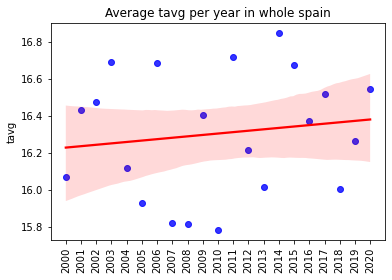

In [15]:
mean_per_year_df_temp = merged_df.groupby(merged_df.time.dt.year).mean()
plot_average_per_year(mean_per_year_df_temp, "tavg")

In [16]:
#getting slope of regression
def get_slope_of_regression(mean_per_year_df, property):
    X=np.array(list(range(len(mean_per_year_df.index)))).reshape(-1, 1)
    y=mean_per_year_df[property]
    reg = LinearRegression().fit(X=X,  y=y)
    return reg.coef_

In [17]:
get_slope_of_regression(mean_per_year_df_temp, "tavg")

array([0.00760828])

In [18]:
regional_dfs.keys()

dict_keys(['GA', 'O', 'S', 'PV', 'CL', 'LO', 'AR', 'CT', 'M', 'CM', 'EX', 'VC', 'IB', 'AN', 'MU', 'CN', 'CE', 'ML'])

In [19]:
def plot_average_property_per_year_per_region(regional_dfs, property):
    x_width = 4
    y_width = 5
    fig, axs = plt.subplots(x_width, y_width,figsize=(20, 10))

    fig.title=f'Average {property} per year per region in whole spain'

    counter=-1
    for i in range(x_width):
        for j in range(y_width):
            counter+=1
            if counter >= len(regional_dfs.keys()):
                break

            reg = list(regional_dfs.keys())[counter]
            reg_df= regional_dfs[reg]
            reg_year_df = reg_df.groupby(reg_df.index.year).mean()

            axs[i, j].title.set_text(reg)
            plt.tight_layout()
            sns.regplot(x=list(range(len(reg_year_df.index))), \
                y=reg_year_df[property] ,scatter_kws={"color": "blue"}, \
                line_kws={"color": "red"}, \
                    ax=axs[i, j])

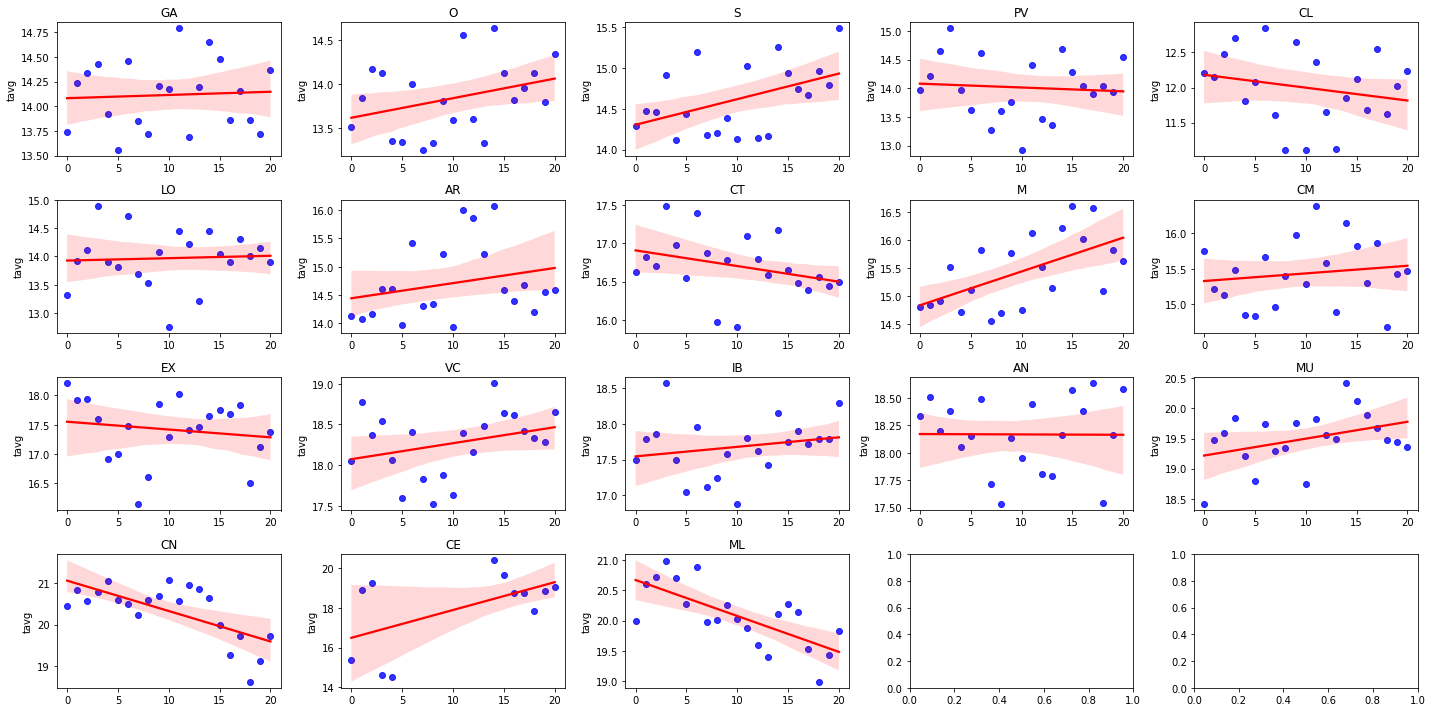

In [20]:
plot_average_property_per_year_per_region(regional_dfs, "tavg")

### Precipitation

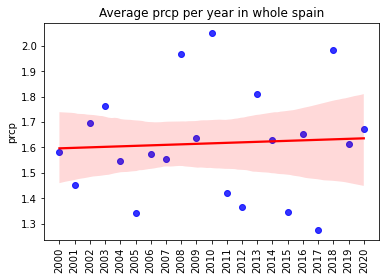

In [21]:
#plot average precipitation per year for spain
mean_per_year_df_pcpt = merged_df.groupby(merged_df.time.dt.year).mean()
plot_average_per_year(mean_per_year_df_pcpt, "prcp")

In [22]:
#getting slope of regression
get_slope_of_regression(mean_per_year_df_pcpt, "prcp")

array([0.00196985])

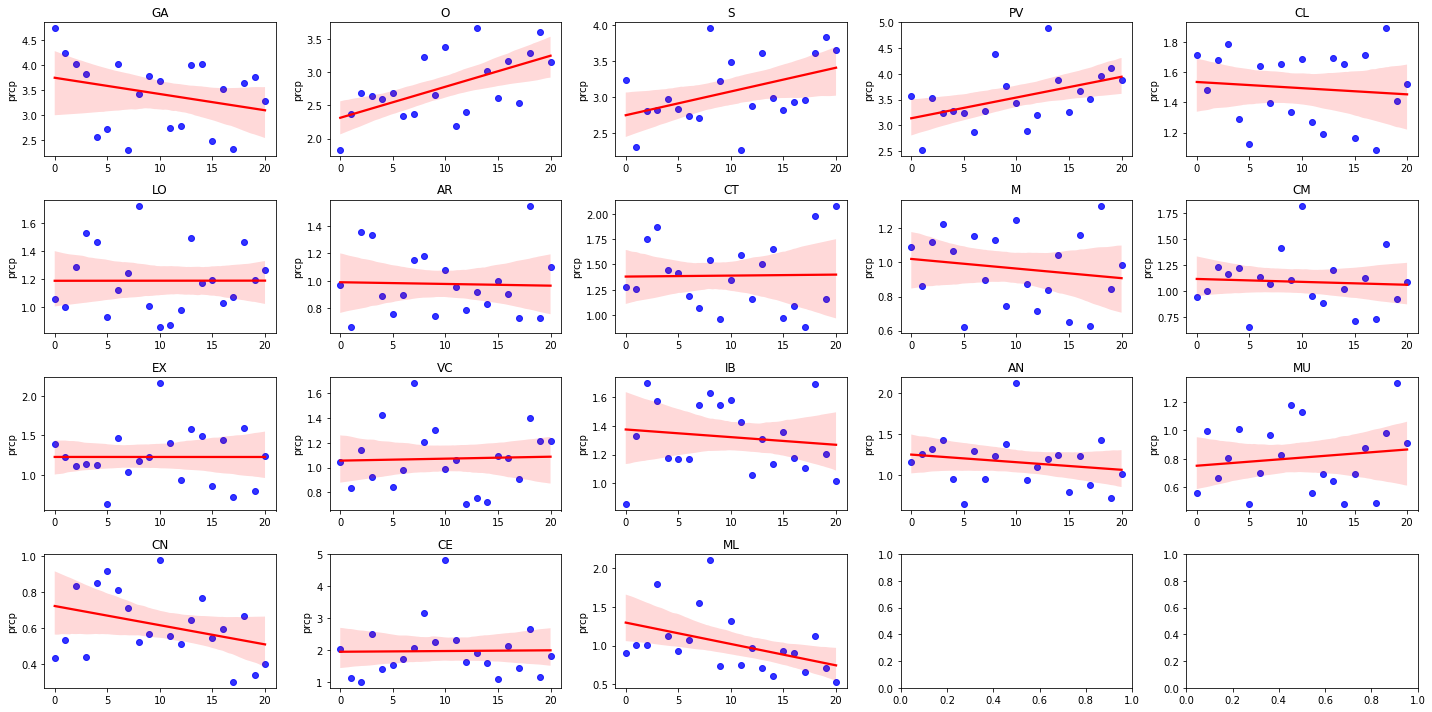

In [23]:
plot_average_property_per_year_per_region(regional_dfs, "prcp")

## 2. River Water Throughput Data

### Time Series

In [24]:
import azure_dataset_connection as adc # importing python file to access the datasets 

In [25]:
#date wise data for the rivers
daywise_df=adc.daily_data_df

Import the necessary libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Check the basic information about the dataset

In [25]:
daywise_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046392 entries, 0 to 1046391
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   GRDC No.  1046392 non-null  int64  
 1   Date      1046392 non-null  object 
 2   Value     1046392 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.0+ MB


In [26]:
daywise_df.head()

GRDC No.        Date  Value
0   6210100  1978-10-01  15.84
1   6210100  1978-10-02  55.70
2   6210100  1978-10-03  13.98
3   6210100  1978-10-04  10.26
4   6210100  1978-10-05  10.26

Check for missing values in the dataset

In [27]:
daywise_df.isnull().sum()

GRDC No.    0
Date        0
Value       0
dtype: int64

Calculating descriptive statistics for the numerical variables in the dataset


In [28]:
daywise_df.describe()

GRDC No.         Value
count  1.046392e+06  1.046392e+06
mean   6.212230e+06 -1.435633e+02
std    9.093272e+02  4.226509e+02
min    6.210100e+06 -9.990000e+02
25%    6.211520e+06  6.200000e-01
50%    6.212480e+06  6.500000e+00
75%    6.212780e+06  2.973000e+01
max    6.213600e+06  8.115000e+03

Calculate the correlation between the variables

In [29]:
daywise_df.corr()

GRDC No.     Value
GRDC No.  1.000000  0.035441
Value     0.035441  1.000000

Calculate the average value for each Grdc no.

In [30]:
daywise_df.groupby(['GRDC No.'])['Value'].mean().head()

GRDC No.
6210100     21.586722
6210210   -277.144041
6210220     -5.622156
6210230   -118.358286
6210310   -127.451367
Name: Value, dtype: float64

Calculate the average value for each date

In [31]:
daywise_df.groupby(['Date'])['Value'].mean().head()

Date
1912-01-01    86.30
1912-01-02    78.50
1912-01-03    67.20
1912-01-04    63.36
1912-01-05    59.78
Name: Value, dtype: float64

 Count the number of records per Grdc no.

In [32]:
daywise_df['GRDC No.'].value_counts().head()


6212700    38625
6212480    38625
6212460    38625
6212750    38625
6212410    38625
Name: GRDC No., dtype: int64

In [33]:
print(daywise_df.columns)

Index(['GRDC No.', 'Date', 'Value'], dtype='object')


 Calculate the average value for each month for a specific Grdc no.

In [34]:
grdc_no = 6210100           
dummy_df=daywise_df[daywise_df['GRDC No.'] == grdc_no ].groupby(daywise_df['Date'].astype("datetime64[ns]").dt.month)['Value'].mean()
dummy_df


Date
1     63.044059
2     48.220029
3     37.788091
4     52.873583
5     24.502930
6      9.485472
7      6.640216
8    -11.297126
9    -68.667909
10    14.396398
11    29.160000
12    43.110027
Name: Value, dtype: float64

 Calculate the average value for each year for a specific Grdc no.

In [35]:
grdc_no = 6210100           
dummy1_df=daywise_df[daywise_df['GRDC No.'] == grdc_no ].groupby(daywise_df['Date'].astype("datetime64[ns]").dt.year)['Value'].mean()
dummy1_df

Date
1978    13.485978
1979    45.488219
1980    36.127486
1981    30.127068
1982    33.469452
1983   -60.986055
1984    30.410000
1985    22.976630
1986    33.148630
1987    27.078027
1988    32.139617
1989    13.299315
1990    14.850667
Name: Value, dtype: float64

Calculating the rolling average for a specific GRDC No.

In [36]:
grdc_no = 6210100
dummy3_df= daywise_df[daywise_df['GRDC No.'] == grdc_no]['Value'].rolling(window=30).mean()
dummy3_df

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
4315    2.396667
4316    2.381333
4317    2.347000
4318    2.331667
4319    2.316333
Name: Value, Length: 4320, dtype: float64

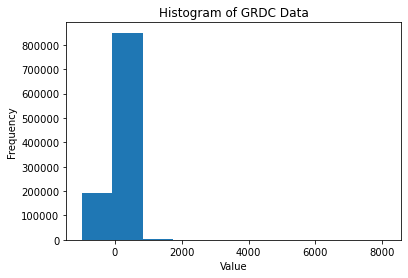

In [37]:
import matplotlib.pyplot as plt

data= daywise_df

plt.hist(data['Value'], bins=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of GRDC Data')
plt.show()

Perform time series analysis 

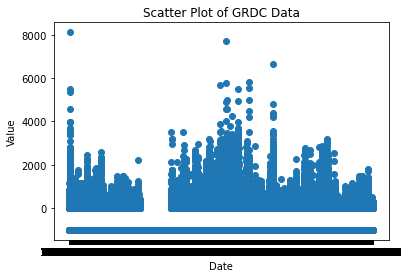

In [38]:
# create a scatter plot of the data
plt.scatter(data['Date'], data['Value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Scatter Plot of GRDC Data')
plt.show()

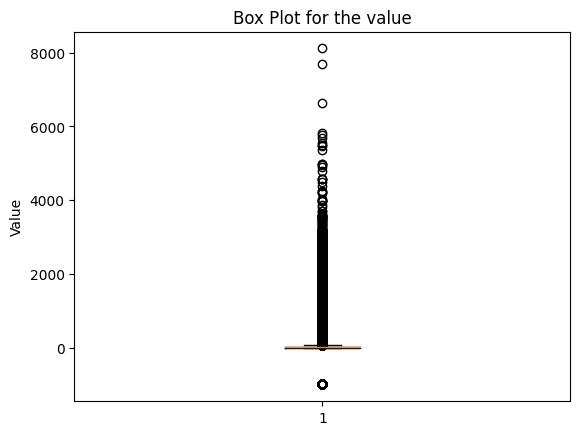

In [ ]:
# create a box plot of the data distribution
plt.boxplot(data['Value'])
plt.ylabel('Value')
plt.title('Box Plot for the value')
plt.show()

Text(0, 0.5, 'Value')

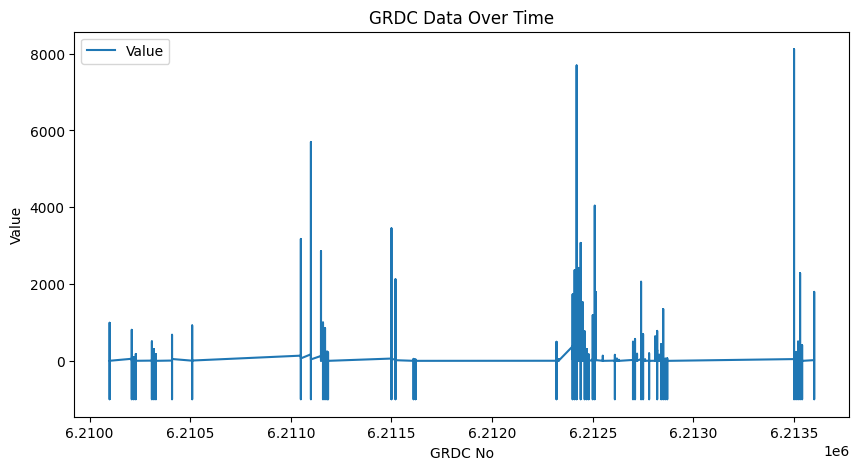

In [ ]:
# explore the data
data.plot(kind='line', x='GRDC No.', y='Value', figsize=(10,5))
plt.title('GRDC Data Over Time')
plt.xlabel('GRDC No')
plt.ylabel('Value')

Text(0, 0.5, 'Value')

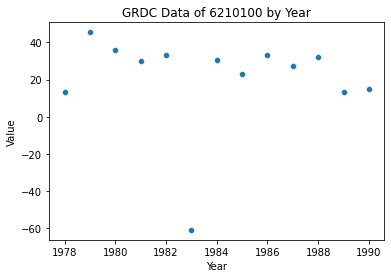

In [391]:
daily_data_df = adc.daily_data_df
filtered_df = daily_data_df[daily_data_df["GRDC No."]==6210100]
mean_df_river = filtered_df.groupby(filtered_df.Date.astype("datetime64[ns]").dt.year).mean()

sns.scatterplot(x='Date', y='Value', data= mean_df_river)
plt.title('GRDC Data of 6210100 by Year')
plt.xlabel('Year')
plt.ylabel('Value')

Calculate the maximum and minimum value for each year for a specific Grdc no.

In [39]:
grdc_no = 6210100
daywise_df[daywise_df['GRDC No.'] == grdc_no].groupby(daywise_df['Date'].astype("datetime64[ns]").dt.year)['Value'].agg(['max', 'min'])

max     min
Date                
1978  116.20    3.80
1979  991.26    4.72
1980  707.58    3.80
1981  609.26    3.80
1982  412.62    2.88
1983  360.67 -999.00
1984  431.05    4.26
1985  431.05    2.88
1986  584.67    3.49
1987  328.54    1.76
1988  421.41    2.19
1989  369.71    2.19
1990  325.52    1.96

### Geo-data

In [112]:
# geographical data for the river
geo_df=adc.geo_data_df.head()
geo_df.head()

GRDC No.        River             Station  Latitude  Longitude  \
0   6210100  RIO NERVION           ECHEVARRI  43.24813   -2.89438   
1   6210210       TAMBRE          PORTOMOURD  42.93673   -8.65912   
2   6210220    LENGUELLE  VILACIDE DE ARRBIA  42.98167   -8.46225   
3   6210230       Tambre              Carolo  42.97602   -8.37750   
4   6210310           EO  San Tirso de Abres  43.41203   -7.14513   

   Catchment Area  Altitude (m ASL)  
0           997.0                18  
1          1526.2              1146  
2           311.0               228  
3           561.0               240  
4           712.0                21

Exploring Data with the different functions or we can say summerizing the data what we are using

In [113]:
print(geo_df.info()) # get a summary of the DataFrame including data types and null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRDC No.          5 non-null      int64  
 1   River             5 non-null      object 
 2   Station           5 non-null      object 
 3   Latitude          5 non-null      float64
 4   Longitude         5 non-null      float64
 5   Catchment Area    5 non-null      float64
 6   Altitude (m ASL)  5 non-null      int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 408.0+ bytes
None


In [114]:
print(geo_df.describe()) # get summary statistics for the numerical variables

           GRDC No.   Latitude  Longitude  Catchment Area  Altitude (m ASL)
count  5.000000e+00   5.000000   5.000000        5.000000          5.000000
mean   6.210214e+06  43.110916  -7.107676      821.440000        330.600000
std    7.503333e+01   0.209009   2.429381      465.795844        468.290295
min    6.210100e+06  42.936730  -8.659120      311.000000         18.000000
25%    6.210210e+06  42.976020  -8.462250      561.000000         21.000000
50%    6.210220e+06  42.981670  -8.377500      712.000000        228.000000
75%    6.210230e+06  43.248130  -7.145130      997.000000        240.000000
max    6.210310e+06  43.412030  -2.894380     1526.200000       1146.000000


Cleaning the data such as dropping the duplicate, missing values and drop them

In [115]:
# Clean the data
# Check for duplicates and drop them
geo_df.drop_duplicates(inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [116]:
# Check for missing values and drop them
geo_df.dropna(inplace=True)

In [117]:
box =  (geo_df.Longitude.min(),   geo_df.Longitude.max(),      
         geo_df.Latitude.min(), geo_df.Latitude.max())
box

(-8.65912, -2.89438, 42.93673, 43.41203)

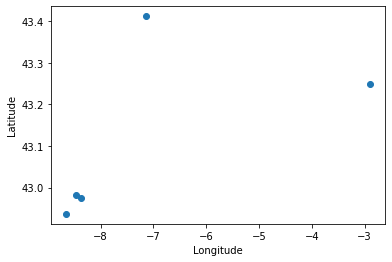

In [118]:
# Visualize the data
geodata = geo_df
plt.scatter(geodata['Longitude'], geodata['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

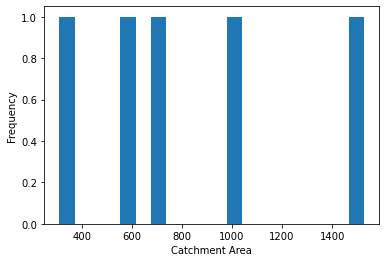

In [119]:
#Histogram of catchment area

plt.hist(geodata['Catchment Area'], bins=20)
plt.xlabel('Catchment Area')
plt.ylabel('Frequency')
plt.show()

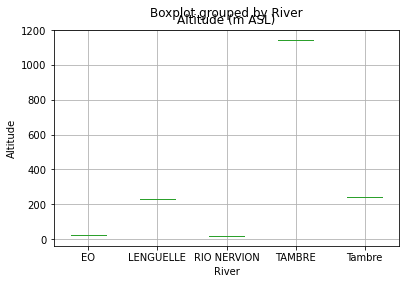

In [120]:
#Boxplot of altitude by river
geodata.boxplot(column='Altitude (m ASL)', by='River') 
plt.xlabel('River') 
plt.ylabel('Altitude') 
plt.show()

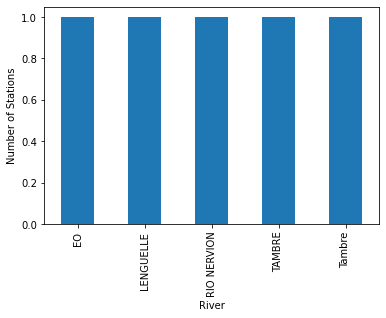

In [121]:
#Bar plot of the number of stations by river
geodata.groupby('River')['Station'].nunique().plot(kind='bar') 
plt.xlabel('River') 
plt.ylabel('Number of Stations') 
plt.show()

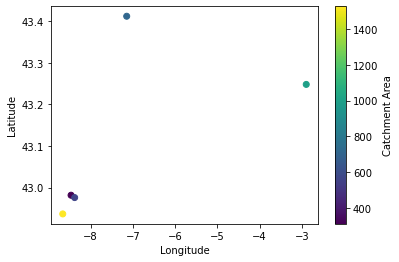

In [122]:
#Scatter plot of latitude and longitude with catchment area represented by color
plt.scatter(geodata['Longitude'], geodata['Latitude'], c=geodata['Catchment Area']) 
plt.xlabel('Longitude') 
plt.ylabel('Latitude') 
plt.colorbar(label='Catchment Area') 
plt.show()


In [123]:
# Calculate the mean altitude
mean_altitude = np.mean(geodata['Altitude (m ASL)'])
print('Mean altitude:', mean_altitude)

Mean altitude: 330.6


In [124]:
#renaming the column
demo_df=geo_df.rename(columns={"Catchment Area": "Catchment_Area"}, errors="raise")
demo_df

GRDC No.        River             Station  Latitude  Longitude  \
0   6210100  RIO NERVION           ECHEVARRI  43.24813   -2.89438   
1   6210210       TAMBRE          PORTOMOURD  42.93673   -8.65912   
2   6210220    LENGUELLE  VILACIDE DE ARRBIA  42.98167   -8.46225   
3   6210230       Tambre              Carolo  42.97602   -8.37750   
4   6210310           EO  San Tirso de Abres  43.41203   -7.14513   

   Catchment_Area  Altitude (m ASL)  
0           997.0                18  
1          1526.2              1146  
2           311.0               228  
3           561.0               240  
4           712.0                21

In [125]:
demo_df['geometry'] = [Point(xy) for xy in zip(demo_df.Latitude, demo_df.Longitude)] 
demo_df

GRDC No.        River             Station  Latitude  Longitude  \
0   6210100  RIO NERVION           ECHEVARRI  43.24813   -2.89438   
1   6210210       TAMBRE          PORTOMOURD  42.93673   -8.65912   
2   6210220    LENGUELLE  VILACIDE DE ARRBIA  42.98167   -8.46225   
3   6210230       Tambre              Carolo  42.97602   -8.37750   
4   6210310           EO  San Tirso de Abres  43.41203   -7.14513   

   Catchment_Area  Altitude (m ASL)                   geometry  
0           997.0                18  POINT (43.24813 -2.89438)  
1          1526.2              1146  POINT (42.93673 -8.65912)  
2           311.0               228  POINT (42.98167 -8.46225)  
3           561.0               240   POINT (42.97602 -8.3775)  
4           712.0                21  POINT (43.41203 -7.14513)

In [61]:
#group the data by river
grouped_data= geo_df.groupby('River')

In [62]:
#calculating the mean altitude and the catchment area
mean_altitudes = grouped_data.mean()['Altitude (m ASL)']
mean_catchment_areas = grouped_data.mean()['Catchment Area']

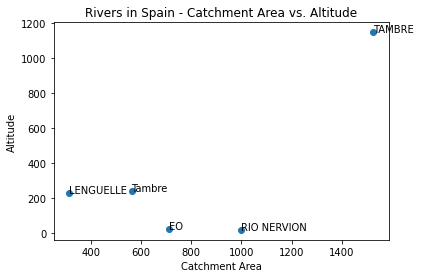

In [63]:
fig, ax = plt.subplots()
ax.scatter(mean_catchment_areas, mean_altitudes)
for i, txt in enumerate(mean_altitudes.index):
    ax.annotate(txt, (mean_catchment_areas[i], mean_altitudes[i]))
plt.xlabel('Catchment Area')
plt.ylabel('Altitude')
plt.title('Rivers in Spain - Catchment Area vs. Altitude')
plt.show()

## 4. Water Quality Data

In [27]:
water_q_df = pd.read_csv("./data/Waterbase_v2021_1_WISE2_csv/Waterbase_v2021_1_T_WISE2_BiologyEQRData.csv")
print(water_q_df.shape)
water_q_df.head()

(57178, 22)


monitoringSiteIdentifier monitoringSiteIdentifierScheme  \
0             FRDR06147840           euMonitoringSiteCode   
1             FRDR06147840           euMonitoringSiteCode   
2             FRDR06147840           euMonitoringSiteCode   
3             FRDR06148200           euMonitoringSiteCode   
4             FRDR06148850           euMonitoringSiteCode   

  parameterWaterBodyCategory parameterNCSWaterBodyType  \
0                         RW                        M5   
1                         RW                        M5   
2                         RW                        M5   
3                         RW                     TG5/2   
4                         RW                        P5   

  parameterNaturalAWBHMWB observedPropertyDeterminandBiologyEQRCode  \
0                 Natural                              EEA_124-01-6   
1                 Natural                              EEA_124-01-6   
2                 Natural                               EEA_13-01-4   
3                    HMWB                              EEA_124-01-6   
4                 Natural                              EEA_124-01-6   

  observedPropertyDeterminandLabel procedureClassificationSystem  \
0                PhytobenthosEQR_G                           NaN   
1                PhytobenthosEQR_G                           NaN   
2                InvertebrateEQR_G                           NaN   
3                PhytobenthosEQR_G                           NaN   
4                PhytobenthosEQR_G                           NaN   

   phenomenonTimeReferenceYear parameterSamplingPeriod  ...  resultEQRValue  \
0                         2010        2010-06--2010-08  ...           1.071   
1                         2011        2011-01--2011-12  ...           0.646   
2                         2010        2010-06--2010-08  ...           1.143   
3                         2011        2011-01--2011-12  ...           0.907   
4                         2010        2010-06--2010-08  ...           0.993   

   resultNormalisedEQRValue  resultObservationStatus  remarks  \
0                     1.000                      NaN      NaN   
1                     0.470                      NaN      NaN   
2                     1.000                      NaN      NaN   
3                     0.769                      NaN      NaN   
4                     0.980                      NaN      NaN   

                                  metadata_versionId  \
0  http://discomap.eea.europa.eu/data/wisesoe/der...   
1  http://discomap.eea.europa.eu/data/wisesoe/der...   
2  http://discomap.eea.europa.eu/data/wisesoe/der...   
3  http://discomap.eea.europa.eu/data/wisesoe/der...   
4  http://discomap.eea.europa.eu/data/wisesoe/der...   

  metadata_beginLifeSpanVersion metadata_statusCode  \
0       2015-11-30 00:00:00.000             derived   
1       2015-11-30 00:00:00.000             derived   
2       2015-11-30 00:00:00.000             derived   
3       2015-11-30 00:00:00.000             derived   
4       2015-11-30 00:00:00.000             derived   

  metadata_observationStatus metadata_statements     UID  
0                        NaN                 NaN  116582  
1                        NaN                 NaN  116583  
2                        NaN                 NaN  116584  
3                        NaN                 NaN  116585  
4                        NaN                 NaN  116586  

[5 rows x 22 columns]

In [28]:
water_q_df.columns

Index(['monitoringSiteIdentifier', 'monitoringSiteIdentifierScheme',
       'parameterWaterBodyCategory', 'parameterNCSWaterBodyType',
       'parameterNaturalAWBHMWB', 'observedPropertyDeterminandBiologyEQRCode',
       'observedPropertyDeterminandLabel', 'procedureClassificationSystem',
       'phenomenonTimeReferenceYear', 'parameterSamplingPeriod',
       'resultEcologicalStatusClassValue', 'resultNumberOfSamples',
       'resultEQRValue', 'resultNormalisedEQRValue', 'resultObservationStatus',
       'remarks', 'metadata_versionId', 'metadata_beginLifeSpanVersion',
       'metadata_statusCode', 'metadata_observationStatus',
       'metadata_statements', 'UID'],
      dtype='object')

In [29]:
water_q_df.resultEcologicalStatusClassValue.head()

0    1
1    3
2    1
3    2
4    1
Name: resultEcologicalStatusClassValue, dtype: int64

In [30]:
mean_per_year_df_wq = water_q_df.groupby(water_q_df.phenomenonTimeReferenceYear).mean()


In [31]:
mean_per_year_df_wq.head()

resultEcologicalStatusClassValue  \
phenomenonTimeReferenceYear                                     
1990                                                 1.322581   
1991                                                 1.354839   
1992                                                 1.375000   
1993                                                 1.387097   
1994                                                 1.285714   

                             resultNumberOfSamples  resultEQRValue  \
phenomenonTimeReferenceYear                                          
1990                                      1.903226        0.976433   
1991                                      2.000000        0.954367   
1992                                      1.968750        0.974774   
1993                                      2.000000        0.955667   
1994                                      1.904762        0.942800   

                             resultNormalisedEQRValue            UID  
phenomenonTimeReferenceYear                                           
1990                                         0.914839  150513.258065  
1991                                         0.889677  150514.258065  
1992                                         0.879719  149549.718750  
1993                                         0.886419  150516.258065  
1994                                         0.906190  148933.571429

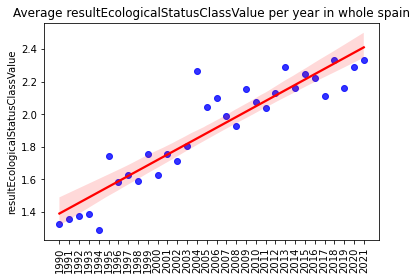

In [32]:
#plot average water quality per year
plot_average_per_year(mean_per_year_df_wq, "resultEcologicalStatusClassValue")

In [33]:
#get regional data for water quality

# 1 get gps data for each record from 2nd spatial data set

#load 2nd data set
water_q_spatial = pd.read_csv("./data/Waterbase_v2021_1_WISE2_csv/Waterbase_v2021_1_S_WISE2_SpatialObject_DerivedData.csv")
print(water_q_spatial.shape)
water_q_spatial.columns

(16766, 22)


Index(['countryCode', 'thematicIdIdentifier', 'thematicIdIdentifierScheme',
       'monitoringSiteIdentifier', 'monitoringSiteIdentifierScheme',
       'monitoringSiteName', 'waterBodyIdentifier',
       'waterBodyIdentifierScheme', 'waterBodyName', 'specialisedZoneType',
       'naturalAWBHMWB', 'reservoir', 'surfaceWaterBodyTypeCode',
       'subUnitIdentifier', 'subUnitIdentifierScheme', 'subUnitName',
       'rbdIdentifier', 'rbdIdentifierScheme', 'rbdName',
       'confidentialityStatus', 'lat', 'lon'],
      dtype='object')

In [34]:
#filter by spain
water_q_spatial.countryCode.unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'HR', 'IE', 'IT', 'LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'UK'], dtype=object)

In [35]:
water_q_spatial = water_q_spatial[water_q_spatial.countryCode=="ES"]

In [36]:
# add lat and long to first data frame
water_q_gps = water_q_df.merge(water_q_spatial[["monitoringSiteIdentifier", "lat", "lon"]], on="monitoringSiteIdentifier")
water_q_gps[["monitoringSiteIdentifier", "lat", "lon"]].head()

monitoringSiteIdentifier       lat      lon
0      ES030ESPFTA53305001  40.56875 -3.88827
1      ES030ESPFTA53305001  40.56875 -3.88827
2      ES030ESPFTA53305001  40.56875 -3.88827
3      ES030ESPFTA53305001  40.56875 -3.88827
4      ES030ESPFTA53305001  40.56875 -3.88827

<AxesSubplot:>

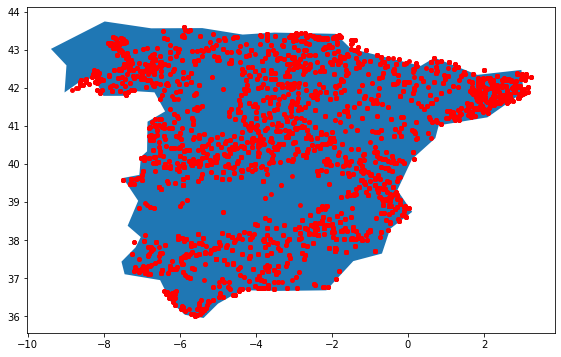

In [37]:
#plot the points
geometry = [Point(xy) for xy in zip(water_q_gps.lon, water_q_gps.lat)]
df= pd.DataFrame(range(len(geometry)))
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
spain = world[world['iso_a3']== 'ESP']
gdf.plot(ax=spain.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

In [38]:
# 2 translate lat/long to region in spain using geopy

In [39]:
#example for single point
from geopy.geocoders import Nominatim

# Set up the geolocator using Nominatim
geolocator = Nominatim(user_agent="my-appjh")

# Set the GPS coordinates
latitude = 40.4167754
longitude = -3.7037902

def get_region_from_gps(latitude,longitude):
    region = None
    # Reverse geocode the coordinates to get the location information
    location = geolocator.reverse(f"{latitude}, {longitude}", language="en")

    # Extract the region from the location information
    try:
        region = location.raw["address"]["state"]
    except:
        return None
    finally:
        if not region:
            return None
    return region

print(get_region_from_gps(latitude, longitude)) # Output: Comunidad de Madrid

Community of Madrid


In [40]:
#check number of rows
water_q_gps.shape

(8471, 24)

In [41]:
# its too many points to make a API request for each of them so lets keep a uniuque point data set
water_q_gps.lat.nunique()

1767

In [42]:
# get number of uniuqe points
len(np.unique(water_q_gps[['lat', 'lon']].values))

5227

In [43]:
# since we cannot access the API for every single point we have to create branches and associate points to them
# we create 10x10 = 100 branches
lat_range = np.linspace(water_q_gps.lat.min(), water_q_gps.lat.max(), 10)
lon_range = np.linspace(water_q_gps.lon.min(), water_q_gps.lon.max(), 10)

In [44]:
#for each center of a branch lets get the region
branches = []
regions = []
lats=[]
longs=[]
for la, lat in enumerate(lat_range):
    for lo, lon in enumerate(lon_range):
        region = get_region_from_gps(lat,lon)
        if region:
            branches.append(f"{str(la)},{str(lo)}")
            regions.append(region)
            lats.append(lat)
            longs.append(lon)

branches_df= pd.DataFrame(
{'branch': branches,
    'region': regions,
    'lat': lats,
    "long": longs
})  

In [45]:
branches_df.head()

branch      region        lat      long
0    0,7  Mostaganem  36.007900  0.549418
1    0,8   Aïn Defla  36.007900  1.889239
2    0,9       Médéa  36.007900  3.229060
3    1,2   Andalusia  36.851817 -6.149688
4    1,3   Andalusia  36.851817 -4.809867

In [46]:
branches_df.region.unique()

array(['Mostaganem', 'Aïn Defla', 'Médéa', 'Andalusia',
       'Region of Murcia', 'Extremadura', 'Castile-La Mancha',
       'Valencian Community', 'Balearic Islands', 'Community of Madrid',
       'Aragon', 'Castile and León', 'Catalonia', 'Galicia', 'Navarre',
       'Occitania', 'Autonomous Community of the Basque Country',
       'Nouvelle-Aquitaine'], dtype=object)

Some of the regions belong to another country. Also we can map the regions to the regions from the weather data. For clarification lets plot the regions for the weather data and the regions for the branches.

In [47]:
#create color column
import matplotlib.colors as mcolors

#get dstinct colors for 18 regions
step_size = len(mcolors.CSS4_COLORS) //18

#for each unique weather region define a color:
weather_region_color_d = {}
color_keys = list(mcolors.CSS4_COLORS.keys())
for wr, weather_reg in enumerate(valid_regions):
    weather_region_color_d[weather_reg] = mcolors.CSS4_COLORS[color_keys[wr*step_size]]

In [48]:
weather_region_color_d

{'GA': '#F0F8FF',
 'O': '#FFEBCD',
 'S': '#FF7F50',
 'PV': '#A9A9A9',
 'CL': '#8B0000',
 'LO': '#FF1493',
 'AR': '#FF00FF',
 'CT': '#808080',
 'M': '#FFF0F5',
 'CM': '#90EE90',
 'EX': '#B0C4DE',
 'VC': '#0000CD',
 'IB': '#191970',
 'AN': '#6B8E23',
 'MU': '#FFEFD5',
 'CN': '#FF0000',
 'CE': '#A0522D',
 'ML': '#4682B4'}

In [49]:
#add custom color to weather stations
stations_es["reg_color"] = stations_es.apply(lambda x: weather_region_color_d[x.region],axis=1)
stations_es.head()

name country region    wmo  icao  latitude  longitude  \
id                                                                            
08001            La Coruna      ES     GA  08001  <NA>   43.3667    -8.4167   
08002  La Coruna / Alvedro      ES     GA  08002  LECO   43.3000    -8.3833   
08008         Lugo / Rozas      ES     GA  08008  <NA>   43.1167    -7.4500   
08011    Asturias / Aviles      ES      O  08011  LEAS   43.5500    -6.0333   
08014                Gijon      ES      O  08014  <NA>   43.5333    -5.6333   

       elevation       timezone hourly_start hourly_end daily_start  \
id                                                                    
08001       58.0  Europe/Madrid   2018-01-27 2023-03-26  1930-10-01   
08002       97.0  Europe/Madrid   1974-10-01 2023-03-26  1971-12-01   
08008      445.0  Europe/Madrid          NaT        NaT  1951-01-01   
08011      127.0  Europe/Madrid   1973-01-01 2023-03-26  1968-08-01   
08014        3.0  Europe/Madrid          NaT        NaT  1973-01-01   

       daily_end monthly_start monthly_end reg_color  
id                                                    
08001 2023-03-20    1930-01-01  2022-01-01   #F0F8FF  
08002 2023-03-20    1971-01-01  2022-01-01   #F0F8FF  
08008 2023-03-21    1951-01-01  2022-01-01   #F0F8FF  
08011 2023-03-17    1968-01-01  2022-01-01   #FFEBCD  
08014 2022-12-31    1982-01-01  2022-01-01   #FFEBCD

<AxesSubplot:>

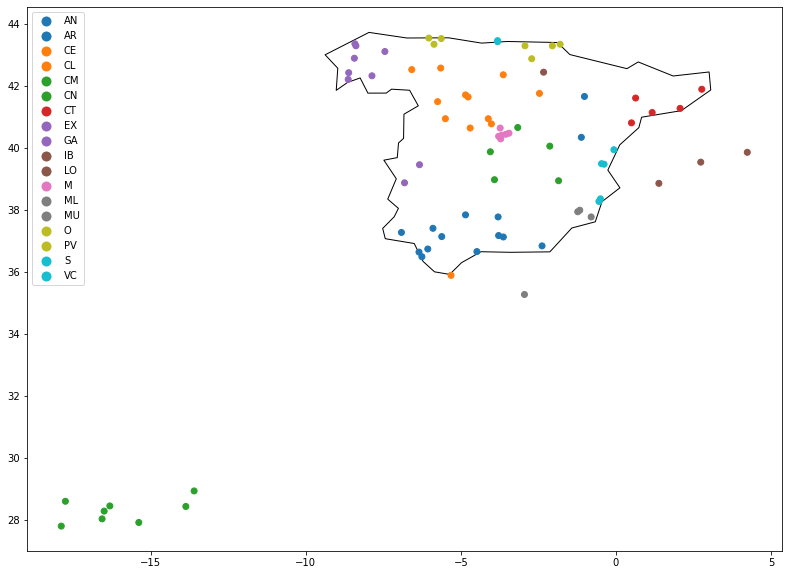

In [50]:
from shapely.geometry import Point
import matplotlib.colors as colors

#plot the points
geometry = [Point(xy) for xy in zip(stations_es.longitude, stations_es.latitude)]
gdf = GeoDataFrame(stations_es, geometry=geometry)   

#uncomment for specific abbrevation
#gdf = gdf[gdf['region']== 'EX']

spain = world[world['iso_a3']== 'ESP']
base = spain.plot(color='white', edgecolor='black',figsize=(15, 10) )
gdf.plot(ax=base, column="region", legend=True) #cmap=colors.ListedColormap(list(weather_region_color_d.values()))

<AxesSubplot:>

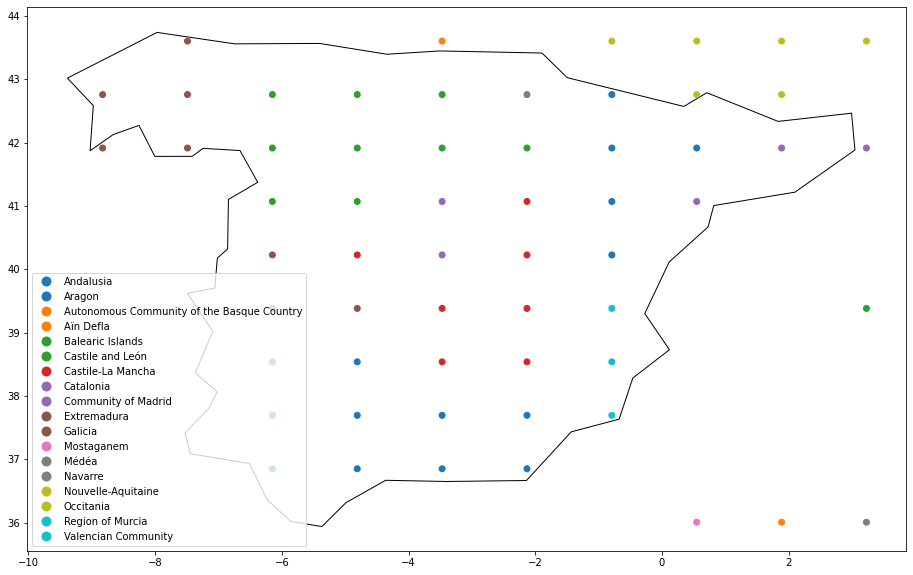

In [51]:
# now lets plot the branch data to compare regions
#plot the points

#plot the points
geometry = [Point(xy) for xy in zip(branches_df.long, branches_df.lat)]
gdf = GeoDataFrame(branches_df, geometry=geometry)   

#gdf = gdf[gdf['region']== 'PV']


spain = world[world['iso_a3']== 'ESP']
base = spain.plot(color='white', edgecolor='black',figsize=(40, 10) )
gdf.plot(ax=base, column="region", legend=True, ) #cmap=colors.ListedColormap(list(weather_region_color_d.values()))

In [52]:
#Comparing the two maps we can come up with following region matching:
# Also Note that we have omitted the three regions (Aïn Defla, Mostaganem, and Médéa) and two territories (Nouvelle-Aquitaine and Occitania) that are not part of Spain.
region_to_abbreviation = {
    'Andalusia': 'AN',
    'Aragon': 'AR',
    'Autonomous Community of the Basque Country': 'S',
    'Balearic Islands': 'IB',
    'Castile and León': 'CL',
    'Castile-La Mancha': 'CM',
    'Catalonia': 'CT',
    'Community of Madrid': 'M',
    'Extremadura': 'EX',
    'Galicia': 'GA',
    'Navarre': 'NA',
    'Region of Murcia': 'MU',
    'Valencian Community': 'VC'
}

In [53]:
#filter non spain out  
branches_df_spain = branches_df[~branches_df["region"].isin(["Mostaganem", "Aïn Defla", "Médéa", "Nouvelle-Aquitaine", "Occitania"])].reset_index(drop=True)

#get weather data regions we have no specific branches for
stations_es[~stations_es.region.isin(region_to_abbreviation.values())].region.unique()

<StringArray>
['O', 'PV', 'LO', 'CN', 'CE', 'ML']
Length: 6, dtype: string

In [54]:
branches_df_spain.head()

branch     region        lat      long                   geometry
0    1,2  Andalusia  36.851817 -6.149688  POINT (-6.14969 36.85182)
1    1,3  Andalusia  36.851817 -4.809867  POINT (-4.80987 36.85182)
2    1,4  Andalusia  36.851817 -3.470046  POINT (-3.47005 36.85182)
3    1,5  Andalusia  36.851817 -2.130224  POINT (-2.13022 36.85182)
4    2,2  Andalusia  37.695733 -6.149688  POINT (-6.14969 37.69573)

Finally we can use the branches_df_spain to map the coordinates of water_q_gps to a region. We simply take the closest point of a center of a branch as reference.

In [55]:
water_q_gps[["lat","lon"]].head()

lat      lon
0  40.56875 -3.88827
1  40.56875 -3.88827
2  40.56875 -3.88827
3  40.56875 -3.88827
4  40.56875 -3.88827

In [56]:
#not for all rows we have the gps data
water_q_gps[["lat","lon"]].isna().sum()

lat    846
lon    846
dtype: int64

In [57]:
# for each coordinate we search the closest branch
import math

def get_distance(point, lat,lon):
    #return math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    dist =  math.sqrt( (lon - point.x)**2 + (lat - point.y)**2 )
    if pd.isna(dist):
        return 999
    else:
        return dist


def get_branch_from_coordinates(row):
    distances = branches_df_spain.geometry.map(lambda x: get_distance(x,lat=row.lat,lon=row.lon))
    min_dist_idx = distances.idxmin()

    return branches_df_spain.region.iloc[min_dist_idx]
    
water_q_gps["region"] = water_q_gps[["lat","lon"]].apply(get_branch_from_coordinates,axis=1)

In [58]:
water_q_gps.region.head()


0    Community of Madrid
1    Community of Madrid
2    Community of Madrid
3    Community of Madrid
4    Community of Madrid
Name: region, dtype: object

<AxesSubplot:>

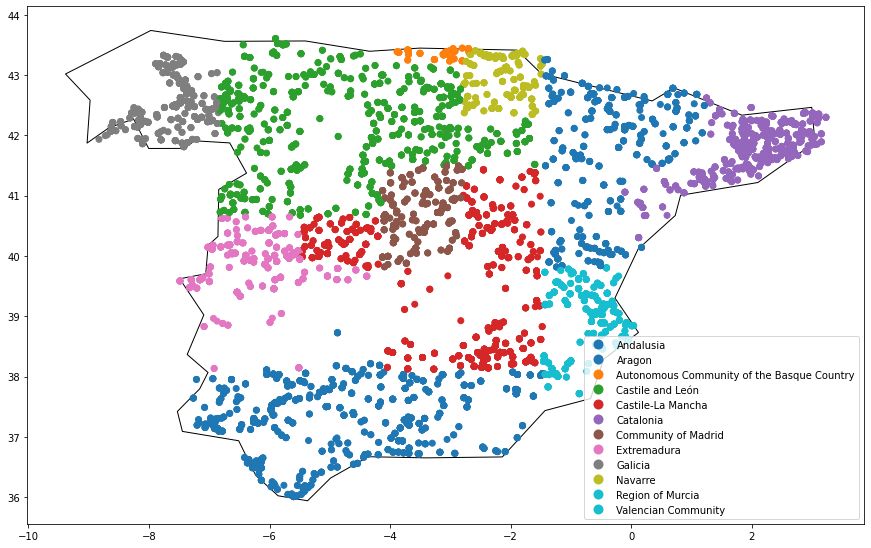

In [59]:
#to confirm, we plot the regions of the water quality control points 
from shapely.geometry import Point
import matplotlib.colors as colors

#plot the points
geometry = [Point(xy) for xy in zip(water_q_gps.lon, water_q_gps.lat)]
gdf = GeoDataFrame(water_q_gps, geometry=geometry)   

#uncomment for specific abbrevation
#gdf = gdf[gdf['region']== 'EX']

spain = world[world['iso_a3']== 'ESP']
base = spain.plot(color='white', edgecolor='black',figsize=(15, 10) )
gdf.plot(ax=base, column="region", legend=True)

In [60]:
len(water_q_gps.region.unique())

12

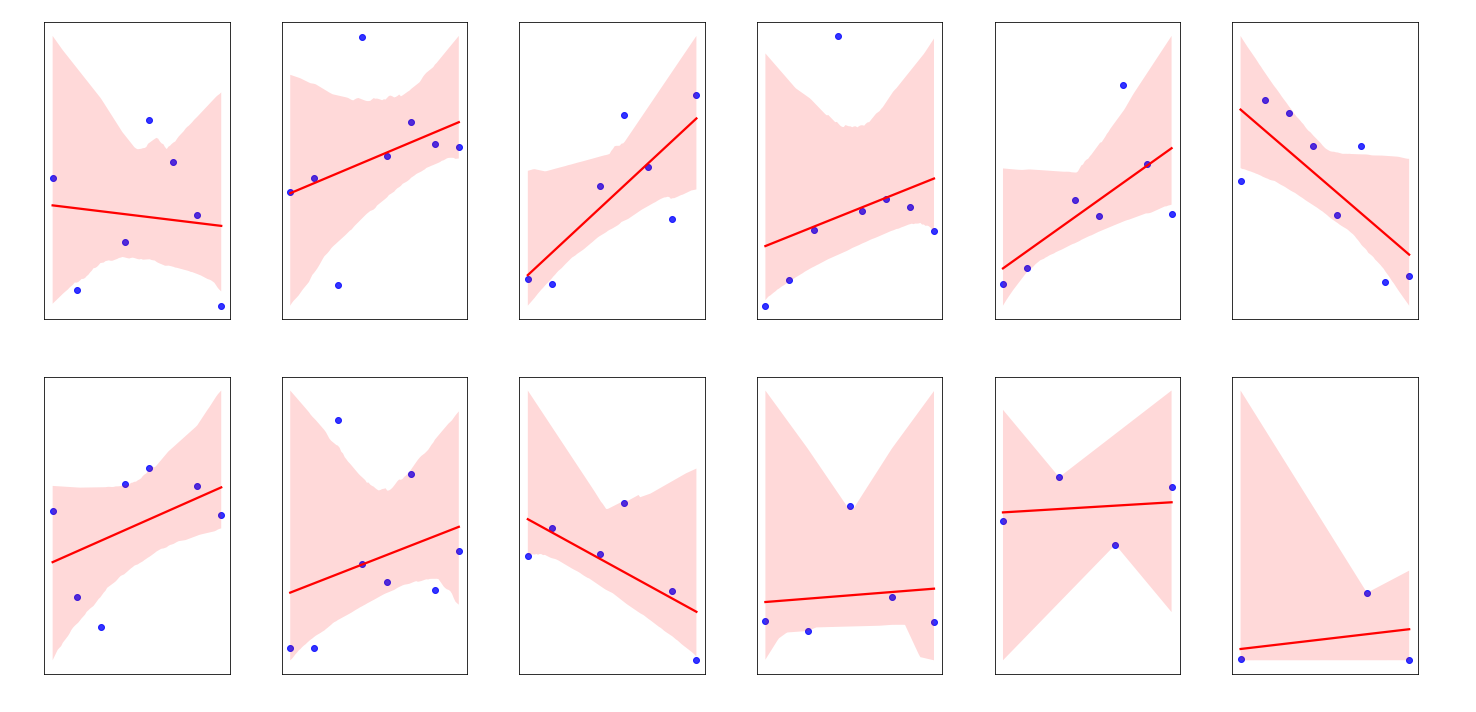

In [61]:
def plot_average_property_per_year_per_region_from_single_df(df, property):
    x_width = 2
    y_width = 6
    fig, axs = plt.subplots(x_width, y_width,figsize=(20, 10))

    fig.title=f'Average {property} per year per region in whole spain'


    counter=-1
    for i in range(x_width):
        for j in range(y_width):
            counter+=1
            if counter >= len(df["region"].unique()):
                break

            reg = list(df["region"].unique())[counter]
            reg_df= df[df["region"]==reg]
            reg_year_df = reg_df.groupby(reg_df.phenomenonTimeReferenceYear).mean()
            reg_year_df = reg_year_df.reset_index(drop=False)

            #display(reg_year_df)
            #break

            axs[i, j].title.set_text(reg)
            axs[i, j].tick_params(axis='both', colors='white')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].title.set_color('white')
            axs[i, j].set_xlabel('year', c="white")
            plt.tight_layout()
            sns.regplot(x=reg_year_df.phenomenonTimeReferenceYear, \
                y=reg_year_df[property] ,scatter_kws={"color": "blue"}, \
                line_kws={"color": "red"}, \
                    ax=axs[i, j])
                    
plot_average_property_per_year_per_region_from_single_df(water_q_gps, "resultEcologicalStatusClassValue")

## Water Availibility

In [62]:
water_avail_df = pd.read_excel("./data/water_availability_spain.xlsx")
print(water_avail_df.shape)
water_avail_df.head()

(2736, 4)


Comunidades y ciudades autónomas  \
0                           España   
1                           España   
2                           España   
3                           España   
4                           España   

                      Principales indicadores     Año  \
0  1. Volumen de agua disponible potabilizada  2020.0   
1  1. Volumen de agua disponible potabilizada  2018.0   
2  1. Volumen de agua disponible potabilizada  2016.0   
3  1. Volumen de agua disponible potabilizada  2014.0   
4  1. Volumen de agua disponible potabilizada  2013.0   

  Total  litres/inhabitant/day  
0                          268  
1                          280  
2                          308  
3                          287  
4                          291

In [63]:
water_avail_es = water_avail_df[water_avail_df["Comunidades y ciudades autónomas"]=="España"]

In [64]:
water_avail_es["Principales indicadores"].unique()

array(['1. Volumen de agua disponible potabilizada',
       '2. Volumen de agua suministrada a la red de abastecimiento público',
       '2.1. Volumen total de agua registrada y distribuida',
       '2.1.1. Volumen de agua registrada y distribuida a los Hogares',
       '2.2. Volumen de agua no registrada', '2.2.1. Pérdidas reales',
       '2.2.2. Pérdidas aparentes',
       '3. Porcentaje de pérdidas reales sobre el volumen de agua suministrada'],
      dtype=object)

In [65]:
water_avail_es_drink = water_avail_es[water_avail_es["Principales indicadores"]=="1. Volumen de agua disponible potabilizada"]
water_avail_es_used = water_avail_es[water_avail_es["Principales indicadores"]=="2.1. Volumen total de agua registrada y distribuida"]
water_avail_merged = pd.concat([water_avail_es_drink, water_avail_es_used])
water_avail_merged = water_avail_merged.drop("Comunidades y ciudades autónomas", axis=1)

In [66]:
water_avail_merged.columns

Index(['Principales indicadores', 'Año', 'Total  litres/inhabitant/day'], dtype='object')

In [67]:
# pivot the data into the correct shape
df = water_avail_merged.pivot(index='Año', columns='Principales indicadores', values='Total  litres/inhabitant/day')

<AxesSubplot:xlabel='Año'>

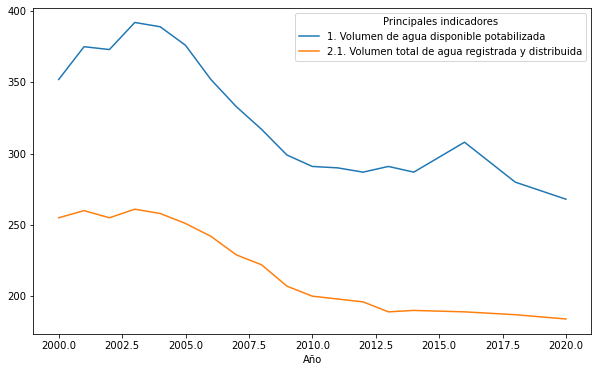

In [68]:
df.plot(figsize=(10, 6))

## Summary

* line plot for all 4 data sets from 2000 to 2020, normlaized on one figure


In [69]:
#weather
mean_per_year_df_weather = mean_per_year_df_temp[["tavg","prcp"]]
mean_per_year_df_weather.index.names = ['year']
mean_per_year_df_weather.head()

tavg      prcp
year                     
2000  16.071190  1.580805
2001  16.432888  1.452047
2002  16.477196  1.697508
2003  16.690234  1.763318
2004  16.117985  1.547586

In [70]:
#river water
daily_data_df = adc.daily_data_df
daily_data_df.Date = daily_data_df.Date.astype("datetime64[ns]")
filtered_data = daily_data_df[daily_data_df["Date"]>= datetime(2000,1,1)]
mean_df_river = filtered_data.groupby(filtered_data.Date.astype("datetime64[ns]").dt.year).mean()
mean_df_river.index = mean_df_river.index.astype("int")
mean_df_river.index.names = ['year']
mean_df_river.drop('GRDC No.', axis=1, inplace=True)
mean_df_river.rename(columns={'Value': 'river water amount'}, inplace=True)
mean_df_river['river water amount'] = mean_df_river['river water amount'].abs()
mean_df_river.head()

river water amount
year                    
2000           36.159379
2001           23.054339
2002           27.146133
2003           30.149074
2004           89.505527

In [71]:
water_avail_es_drink.columns

Index(['Comunidades y ciudades autónomas', 'Principales indicadores', 'Año',
       'Total  litres/inhabitant/day'],
      dtype='object')

In [72]:
#available drinking water
water_avail_drink = water_avail_es_drink[["Año", "Total  litres/inhabitant/day"]].copy()
water_avail_drink.rename(columns={'Año': 'year', "Total  litres/inhabitant/day":"lit/inh/day"}, inplace=True)
water_avail_drink.year = water_avail_drink.year.astype("int") 
water_avail_drink.set_index("year", inplace=True)
water_avail_drink.head()

lit/inh/day
year            
2020         268
2018         280
2016         308
2014         287
2013         291

In [73]:
# water quality
water_qual = mean_per_year_df_wq[["resultEcologicalStatusClassValue"]]
water_qual_filtered = water_qual.loc[2000:2020]
water_qual_filtered.index.names=["year"]
water_qual_filtered.head()

resultEcologicalStatusClassValue
year                                  
2000                          1.628866
2001                          1.757895
2002                          1.714286
2003                          1.806122
2004                          2.263598

In [74]:
# join all four over year
import functools as ft
my_dfs = [mean_per_year_df_weather,mean_df_river, water_avail_drink,  water_qual_filtered]
df_summary = ft.reduce(lambda left, right: pd.merge(left, right, on='year'), my_dfs)

In [75]:
df_summary

tavg      prcp  river water amount lit/inh/day  \
year                                                        
2000  16.071190  1.580805           36.159379         352   
2001  16.432888  1.452047           23.054339         375   
2002  16.477196  1.697508           27.146133         373   
2003  16.690234  1.763318           30.149074         392   
2004  16.117985  1.547586           89.505527         389   
2005  15.927528  1.340561           38.436342         376   
2006  16.687421  1.574337           11.616383         352   
2007  15.818376  1.552933            9.622700         333   
2008  15.814627  1.968934            3.220467         317   
2009  16.403559  1.637317            7.083303         299   
2010  15.780446  2.051261            1.200767         291   
2011  16.720618  1.421069           30.202551         290   
2012  16.217387  1.366048           16.917120         287   
2013  16.013459  1.810419           48.855984         291   
2014  16.850524  1.630827           51.513579         287   
2016  16.375320  1.653264           51.018335         308   

      resultEcologicalStatusClassValue  
year                                    
2000                          1.628866  
2001                          1.757895  
2002                          1.714286  
2003                          1.806122  
2004                          2.263598  
2005                          2.046980  
2006                          2.100543  
2007                          1.987749  
2008                          1.925054  
2009                          2.153727  
2010                          2.073336  
2011                          2.039971  
2012                          2.131169  
2013                          2.291880  
2014                          2.164039  
2016                          2.221085

<AxesSubplot:xlabel='year'>

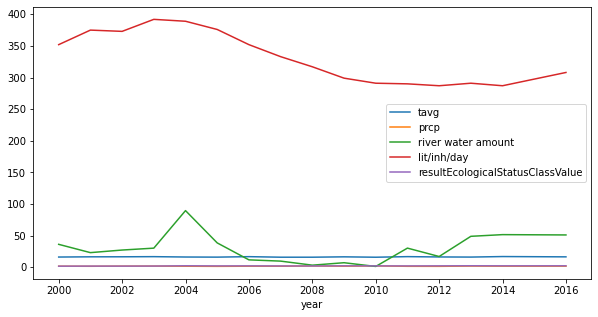

In [76]:
df_summary.plot(figsize=(10,5))

In [77]:
#normalize values, col wise
df_summary_norm=(df_summary-df_summary.mean())/df_summary.std()

<AxesSubplot:xlabel='year'>

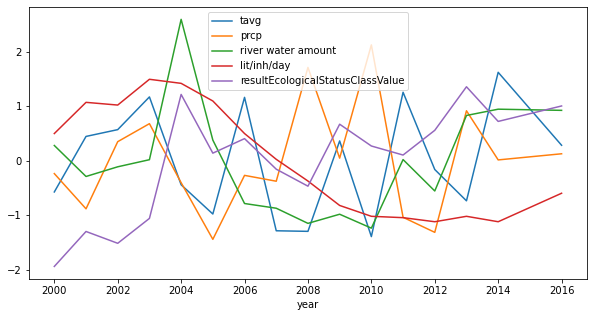

In [78]:
df_summary_norm.plot(figsize=(10,5))

In [79]:
for col in df_summary.columns:
    print(col, get_slope_of_regression(df_summary, col)[0])

tavg 0.004797324621319462
prcp 0.006397688749335925
river water amount 0.13422803400948902
lit/inh/day -7.2705882352941185
resultEcologicalStatusClassValue 0.03250788333091396


In Spain from 2000 to 2020:
 * The average temperature is rising slowly
 * The average precipitation is increasing
 * The average river water amount is accordingly increasing as well
 * However the amount of lit/inh/day which are for drinking availabel is decreasing a lot.
 * On the other hand water quality is increasing steadily

Outcome: More rain does not certainly help to have more drinkwater available. Especially if it rains a lot during short amount of time, most water cannot be consumed by the soil.

## Save final data frame in Azure SQL

In [96]:
df_summary

tavg      prcp  river water amount lit/inh/day  \
year                                                        
2000  16.071190  1.580805           36.159379         352   
2001  16.432888  1.452047           23.054339         375   
2002  16.477196  1.697508           27.146133         373   
2003  16.690234  1.763318           30.149074         392   
2004  16.117985  1.547586           89.505527         389   
2005  15.927528  1.340561           38.436342         376   
2006  16.687421  1.574337           11.616383         352   
2007  15.818376  1.552933            9.622700         333   
2008  15.814627  1.968934            3.220467         317   
2009  16.403559  1.637317            7.083303         299   
2010  15.780446  2.051261            1.200767         291   
2011  16.720618  1.421069           30.202551         290   
2012  16.217387  1.366048           16.917120         287   
2013  16.013459  1.810419           48.855984         291   
2014  16.850524  1.630827           51.513579         287   
2016  16.375320  1.653264           51.018335         308   

      resultEcologicalStatusClassValue  
year                                    
2000                          1.628866  
2001                          1.757895  
2002                          1.714286  
2003                          1.806122  
2004                          2.263598  
2005                          2.046980  
2006                          2.100543  
2007                          1.987749  
2008                          1.925054  
2009                          2.153727  
2010                          2.073336  
2011                          2.039971  
2012                          2.131169  
2013                          2.291880  
2014                          2.164039  
2016                          2.221085

In [114]:
server = 'jh339sqlserver.database.windows.net'
database = 'my-azure-sql-db'
username = 'jhorn'
password = getpass()
driver= '{ODBC Driver 17 for SQL Server}'
connection_string= 'DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password

conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = conn.cursor()


cursor.execute(f'DROP TABLE IF EXISTS summary_data')
conn.commit()


cursor.execute('''
		CREATE TABLE summary_data (
			year int primary KEY,
			tavg float,
			prcp float,
            "river water amount" float,
            "lit/inh/day" int,
            resultEcologicalStatusClassValue float
			)
               ''')

conn.commit()
#reset index
df_summary_no_idx=df_summary.reset_index(drop=False)
# Insert Dataframe into SQL Server:
for index, row in df_summary_no_idx.iterrows():
     cursor.execute('INSERT INTO summary_data (year,tavg,prcp,"river water amount", "lit/inh/day", resultEcologicalStatusClassValue) values(?,?,?,?,?,?)', \
		row.year, row.tavg, row.prcp, row["river water amount"], row["lit/inh/day"], row["resultEcologicalStatusClassValue"])
conn.commit()
cursor.close()

## Load Data Back for sake of practise


In [142]:
server = 'jh339sqlserver.database.windows.net'
database = 'my-azure-sql-db'
username = 'jhorn'
password = getpass()
driver= '{ODBC Driver 17 for SQL Server}'
connection_string= 'DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password

conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = conn.cursor()

cursor.execute("SELECT "
    "* "
    "FROM summary_data")
rows = cursor.fetchall()
#convert row to list
rows = [[elem for elem in row] for row in rows]


In [126]:
col_names = [i[0] for i in cursor.description]

In [143]:
df_loaded = pd.DataFrame(rows,columns=col_names)

In [144]:
df_loaded

year       tavg      prcp  river water amount  lit/inh/day  \
0   2000  16.071190  1.580805           36.159379          352   
1   2001  16.432888  1.452047           23.054339          375   
2   2002  16.477196  1.697508           27.146133          373   
3   2003  16.690234  1.763318           30.149074          392   
4   2004  16.117985  1.547586           89.505527          389   
5   2005  15.927528  1.340561           38.436342          376   
6   2006  16.687421  1.574337           11.616383          352   
7   2007  15.818376  1.552933            9.622700          333   
8   2008  15.814627  1.968934            3.220467          317   
9   2009  16.403559  1.637317            7.083303          299   
10  2010  15.780446  2.051261            1.200767          291   
11  2011  16.720618  1.421069           30.202551          290   
12  2012  16.217387  1.366048           16.917120          287   
13  2013  16.013459  1.810419           48.855984          291   
14  2014  16.850524  1.630827           51.513579          287   
15  2016  16.375320  1.653264           51.018335          308   

    resultEcologicalStatusClassValue  
0                           1.628866  
1                           1.757895  
2                           1.714286  
3                           1.806122  
4                           2.263598  
5                           2.046980  
6                           2.100543  
7                           1.987749  
8                           1.925054  
9                           2.153727  
10                          2.073336  
11                          2.039971  
12                          2.131169  
13                          2.291880  
14                          2.164039  
15                          2.221085

## Bonus: Sentiment Analysis on article about rivers in spain

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
import requests
from bs4 import BeautifulSoup

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Get the blog posts from a URL
url = 'https://www.welgrowgroup.com/blog/the-most-beautiful-rivers-in-spain-to-visit'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
blog_posts = [post.text for post in soup.find_all('div', class_='blog-post')]

# Tokenize the blog posts
tokens = word_tokenize(' '.join(blog_posts))

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

# print the stop words
print(stop_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{"needn't", 'yourselves', 'because', "doesn't", 'can', 'same', 't', 'where', 've', 'this', 'off', 'most', 'them', 'having', 'too', "mustn't", 'who', 'when', 'the', 'all', 'if', 'ain', 'these', 'below', 'aren', 'between', 'isn', 'haven', 'then', "weren't", 'but', 'now', 'once', 'hadn', 'into', 'wasn', 'so', 'mightn', 'doesn', 'there', 'she', 'not', 'is', 'did', 'an', 'each', "you've", 'hers', 'being', 'for', 'only', 'themselves', 'in', 'been', 'no', 's', 'under', 'against', 'should', 'again', 'here', "you'll", 'am', 'her', 'to', "hasn't", 'our', 'such', 'doing', 'or', 'will', 'theirs', 'at', "shouldn't", "you're", 'hasn', 'about', 'than', 'down', 'few', 'we', 'your', "aren't", 'i', 'mustn', 'myself', 'some', 'be', 'whom', 'other', 'it', 'how', "should've", "you'd", 'yourself', "don't", 'd', 'you', 'until', 'further', 'above', "it's", 'a', 'ourselves', 'have', "haven't", 'weren', 'he', 'with', 'more', 'wouldn', 'had', 'on', 'own', 'are', "shan't", 'while', 'from', 'my', 'before', 'should

In [2]:
len(stop_words)

179

In [3]:
#to analyze the sentiment of the text in a blog post about Spanish rivers
import nltk
from nltk.sentiment import SentimentAnalyzer

text = soup.get_text(strip=True)

# Use NLTK's built-in sentiment analyzer to analyze the sentiment of the text
sentiment_analyzer = nltk.sentiment.SentimentIntensityAnalyzer()
sentiment_scores = sentiment_analyzer.polarity_scores(text)

# Print the sentiment scores
print(f"Positive sentiment: {sentiment_scores['pos']:.2f}")
print(f"Negative sentiment: {sentiment_scores['neg']:.2f}")
print(f"Neutral sentiment: {sentiment_scores['neu']:.2f}")
print(f"Compound sentiment: {sentiment_scores['compound']:.2f}")

Positive sentiment: 0.18
Negative sentiment: 0.04
Neutral sentiment: 0.78
Compound sentiment: 1.00
